In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from tslearn.datasets import UCR_UEA_datasets

# Load dataset (Replace 'DatasetName' with your actual dataset)
ucr = UCR_UEA_datasets(use_cache=True)
X_train, y_train, X_test, y_test = ucr.load_dataset(
    "UWaveGestureLibrary"
)  # Good dataset : Epilepsy, UWaveGestureLibrary, HandMovementDirection

X_train.shape

/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


(120, 315, 3)

In [4]:
from sklearn.preprocessing import MinMaxScaler

batch_size, seq_len, n_dim = X_train.shape
test_batch_size = X_test.shape[0]

scl = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, n_dim)
X_test_reshaped = X_test.reshape(-1, n_dim)

X_train_scaled = scl.fit_transform(X_train_reshaped)
X_test_scaled = scl.transform(X_test_reshaped)

X_train = X_train_scaled.reshape(batch_size, seq_len, n_dim)
X_test = X_test_scaled.reshape(test_batch_size, seq_len, n_dim)

In [5]:
y_train = y_train.astype(float).astype(int)
y_test = y_test.astype(float).astype(int)

In [6]:
import sys

sys.path.append("..")

In [7]:
from torch_mas.batch.trainer import BaseTrainer
from torch_mas.batch.internal_model import NClass
from torch_mas.batch.activation_function import BaseActivation
from torch_mas.data import DataBuffer

_, seq_len, input_dim = X_train.shape

internal_nodel = NClass(
    input_dim=input_dim,
    output_dim=1,
    memory_length=input_dim + 1,
)

activation = BaseActivation(
    seq_len=seq_len, input_dim=input_dim, output_dim=1, alpha=0.1, neighbor_rate=0.9
)

trainer = BaseTrainer(
    activation,
    internal_nodel,
    R=0.1,
    bad_th=0.01,
    n_epochs=10,
)

dataset = DataBuffer(X_train, y_train)

trainer.fit(dataset)
trainer.n_agents

438

In [8]:
import torch
from sklearn.metrics import accuracy_score


y_pred = trainer.predict(torch.tensor(X_test, dtype=torch.float32))
print(accuracy_score(y_pred, y_test))

0.884375


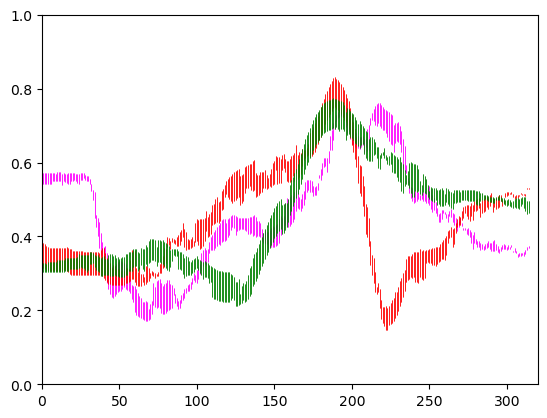

In [9]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

fig, ax = plt.subplots()
colors = ["red", "blue", "green", "purple", "orange", "grey", "magenta", "brown"]

# activation.orthotopes is a tensor of size (n_agents, seq_len, n_dim, 2)
orthotopesdim0 = activation.orthotopes[:3, :, 0, :]

for agent_id in range(orthotopesdim0.shape[0]):
    y = internal_nodel.base_prediction[agent_id]

    lines = []
    for time in range(orthotopesdim0[agent_id].shape[0]):
        for h in range(orthotopesdim0[agent_id][time].shape[0]):
            lines.append(
                [
                    (time, orthotopesdim0[agent_id][time][0]),
                    (time, orthotopesdim0[agent_id][time][1]),
                ]
            )
    lc = LineCollection(lines, colors=colors[int(y - 1)], linewidths=0.5, alpha=0.9)
    ax.add_collection(lc)

ax.set_xlim(0, 320)
plt.show()

In [10]:
(activation.orthotopes[:, :10, :, 1] - activation.orthotopes[:, :10, :, 0]).mean(
    dim=-1
).shape

torch.Size([438, 10])

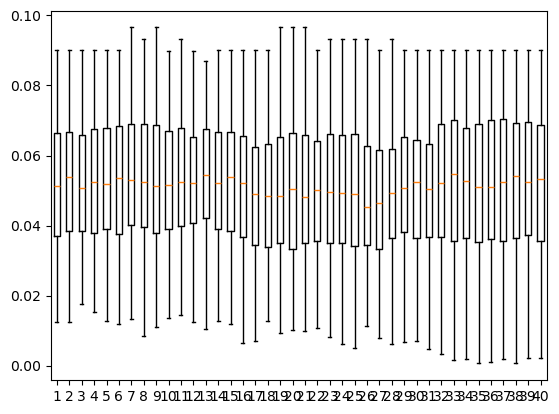

In [11]:
plt.boxplot(
    (activation.orthotopes[:, 40:80, 2, 1] - activation.orthotopes[:, 40:80, 2, 0])
)
plt.show()

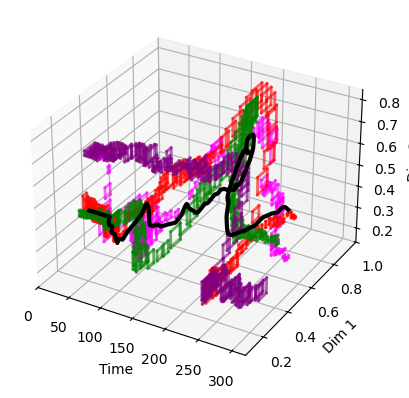

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# %matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

colors = ["red", "blue", "green", "purple", "orange", "grey", "magenta", "brown"]

# activation.orthotopes is a tensor of size (n_agents, seq_len, n_dim, 2)
orthotopesdim0 = activation.orthotopes[:4, :, 0, :]
orthotopesdim1 = activation.orthotopes[:4, :, 1, :]  # Using second spatial dimension

for agent_id in range(orthotopesdim0.shape[0]):
    y = internal_nodel.base_prediction[agent_id]

    for time in range(0, orthotopesdim0.shape[1], 3):
        x = time  # Time axis
        z_min, z_max = orthotopesdim0[agent_id, time]
        y_min, y_max = orthotopesdim1[agent_id, time]

        # Vertical lines in 3D (connecting min/max bounds)
        ax.plot(
            [x, x],
            [y_min, y_min],
            [z_min, z_max],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )
        ax.plot(
            [x, x],
            [y_max, y_max],
            [z_min, z_max],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )

        # Horizontal lines in the Z direction
        ax.plot(
            [x, x],
            [y_min, y_max],
            [z_min, z_min],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )
        ax.plot(
            [x, x],
            [y_min, y_max],
            [z_max, z_max],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )

time = np.linspace(0, 315, 315)  # Time steps (Z-axis)

ts0 = X_train[1, :, 0]
ts1 = X_train[1, :, 1]

ax.plot3D(time, ts0, ts1, color="black", linewidth=3, label="3D Signal")

ax.set_xlim(0, 320)
ax.set_xlabel("Time")
ax.set_ylabel("Dim 1")
ax.set_zlabel("Dim 2")

plt.show()